In [3]:
%matplotlib inline
import pandas as pd
import pickle
import re
import time
from collections import Counter, defaultdict
import numpy as np
import csv
import random
from scipy import stats
from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# copied from https://github.com/Conway/perspective; the pip installation fails.

import json
import requests
import warnings
import markdown
try:
    from html.parser import HTMLParser
except ImportError:
    from HTMLParser import HTMLParser

def validate_language(language):
    # ISO 639-1 code validation
    # language source: https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
    codes = ["ab", "aa", "ae", "af", "ak", "am", "an", "ar", "as", "av", "ay",
             "az", "ba", "be", "bg", "bh", "bi", "bm", "bn", "bo", "br", "bs",
             "ca", "ce", "ch", "co", "cr", "cs", "cu", "cv", "cy", "da", "de",
             "dv", "dz", "ee", "el", "en", "eo", "es", "et", "eu", "fa", "ff",
             "fi", "fj", "fo", "fr", "fy", "ga", "gd", "gl", "gn", "gu", "gv",
             "ha", "he", "hi", "ho", "hr", "ht", "hu", "hy", "hz", "ia", "id",
             "ie", "ig", "ii", "ik", "io", "is", "it", "iu", "ja", "jv", "ka",
             "kg", "ki", "kj", "kk", "kl", "km", "kn", "ko", "kr", "ks", "ku",
             "kv", "kw", "ky", "la", "lb", "lg", "li", "ln", "lo", "lt", "lu",
             "lv", "mg", "mh", "mi", "mk", "ml", "mn", "mr", "ms", "mt", "my",
             "na", "nb", "nd", "ne", "ng", "nl", "nn", "no", "nr", "nv", "ny",
             "oc", "oj", "om", "or", "os", "pa", "pi", "ps", "pt", "qu", "rm",
             "rn", "ro", "ru", "rw", "sa", "sc", "sd", "se", "sg", "si", "sk",
             "sl", "sm", "sn", "so", "sq", "sr", "ss", "st", "su", "sv", "sw",
             "ta", "te", "tg", "th", "ti", "tk", "tl", "tn", "to", "tr", "ts",
             "tt", "tw", "ty", "ug", "uk", "ur", "uz", "ve", "vi", "vo", "wa",
             "wo", "xh", "yi", "yo", "za", "zh", "zu"]
    return language.lower() in codes


def remove_html(text, md=False):
    if md:
        text = markdown.markdown(text)
    # credit: stackoverflow
    class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.fed = []
        def handle_data(self, d):
            self.fed.append(d)
        def get_data(self):
            return ''.join(self.fed)

    s = MLStripper()
    s.feed(text)
    return s.get_data()

# allowed test types
allowed = ["TOXICITY",
           "SEVERE_TOXICITY",
           "TOXICITY_FAST",
           "ATTACK_ON_AUTHOR",
           "ATTACK_ON_COMMENTER",
           "INCOHERENT",
           "INFLAMMATORY",
           "OBSCENE",
           "OFF_TOPIC",
           "UNSUBSTANTIAL",
           "LIKELY_TO_REJECT"]

class Perspective(object):

    base_url = "https://commentanalyzer.googleapis.com/v1alpha1"

    def __init__(self, key):
        self.key = key

    def score(self, text, tests=["TOXICITY"], context=None, languages=None, do_not_store=False, token=None, text_type=None):
        # data validation
        # make sure it's a valid test
        # TODO: see if an endpoint that has valid types exists
        if isinstance(tests, str):
            tests = [tests]
        if not isinstance(tests, (list, dict)) or tests is None:
            raise ValueError("Invalid list/dictionary provided for tests")
        if isinstance(tests, list):
            new_data = {}
            for test in tests:
                new_data[test] = {}
            tests = new_data
        if text_type:
            if text_type.lower() == "html":
                text = remove_html(text)
            elif text_type.lower() == "md":
                text = remove_html(text, md=True)
            else:
                raise ValueError("{0} is not a valid text_type. Valid options are 'html' or 'md'".format(str(text_type)))

        for test in tests.keys():
            if test not in allowed:
                warnings.warn("{0} might not be accepted as a valid test.".format(str(test)))
            for key in tests[test].keys():
                if key not in ["scoreType", "scoreThreshhold"]:
                    raise ValueError("{0} is not a valid sub-property for {1}".format(key, test))

        # The API will only grade text less than 3k characters long
        if len(text) > 3000:
            # TODO: allow disassembly/reassembly of >3000char comments
            warnings.warn("Perspective only allows 3000 character strings. Only the first 3000 characters will be sent for processing")
            text = text[:3000]
        new_langs = []
        if languages:
            for language in languages:
                language = language.lower()
                if validate_language(language):
                    new_langs.append(language)

        # packaging data
        url = Perspective.base_url + "/comments:analyze"
        querystring = {"key": self.key}
        payload_data = {"comment": {"text": text}, "requestedAttributes": {}}
        for test in tests.keys():
            payload_data["requestedAttributes"][test] = tests[test]
        if new_langs != None:
            payload_data["languages"] = new_langs
        if do_not_store:
            payload_data["doNotStore"] = do_not_store
        payload = json.dumps(payload_data)
        headers = {'content-type': "application/json"}
        response = requests.post(url,
                            data=payload,
                            headers=headers,
                            params=querystring)
        data = response.json()
        if "error" in data.keys():
            raise PerspectiveAPIException(data["error"]["message"])
        c = Comment(text, [], token)
        base = data["attributeScores"]
        for test in tests.keys():
            score = base[test]["summaryScore"]["value"]
            score_type = base[test]["summaryScore"]["type"]
            a = Attribute(test, [], score, score_type)
            for span in base[test]["spanScores"]:
                beginning = span["begin"]
                end = span["end"]
                score = span["score"]["value"]
                score_type = span["score"]["type"]
                s = Span(beginning, end, score, score_type, c)
                a.spans.append(s)
            c.attributes.append(a)
        return c

class Comment(object):
    def __init__(self, text, attributes, token):
        self.text = text
        self.attributes = attributes
        self.token = token

    def __getitem__(self, key):
        if key.upper() not in allowed:
            raise ValueError("value {0} does not exist".format(key))
        for attr in self.attributes:
            if attr.name.lower() == key.lower():
                return attr
        raise ValueError("value {0} not found".format(key))

    def __str__(self):
        return self.text

    def __repr__(self):
        count = 0
        num = 0
        for attr in self.attributes:
            count += attr.score
            num += 1
        return "<({0}) {1}>".format(str(count/num), self.text)

    def __iter__(self):
        return iter(self.attributes)

    def __len__(self):
        return len(self.text)

class Attribute(object):
    def __init__(self, name, spans, score, score_type):
        self.name = name
        self.spans = spans
        self.score = score
        self.score_type = score_type

    def __getitem__(self, index):
        return self.spans[index]

    def __iter__(self):
        return iter(self.spans)

class Span(object):
    def __init__(self, begin, end, score, score_type, comment):
        self.begin = begin
        self.end = end
        self.score = score
        self.score_type = score_type
        self.comment = comment

    def __str__(self):
        return self.comment.text[self.begin:self.end]

    def __repr__(self):
        return "<({0}) {1}>".format(self.score, self.comment.text[self.begin:self.end])

class PerspectiveAPIException(Exception):
    pass

In [15]:
#from perspective.perspective import Perspective # after `pip install perspective`, might also need to manually put files from (https://github.com/Conway/perspective/tree/master/perspective) to your conda environment's site-packages folder. See the issue here (https://github.com/Conway/perspective/issues/9).
# My API key
papi = Perspective(None) # hidden, you might want to substitute with your own key

In [5]:
_trndf = pd.read_csv("SBFv2.trn.csv")
_devdf = pd.read_csv("SBFv2.dev.csv")
_tstdf = pd.read_csv("SBFv2.tst.csv")
trndf = pd.concat([_trndf, _devdf, _tstdf], ignore_index=True)

In [6]:
len(trndf)

147139

In [7]:
trndf

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,363A7XIFV4G2799C5V96YERJA9AVAM,mod-liberal,white,35.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN
2,0.0,0.33,0.0,NaN,0.5,man,NaN,NaN,NaN,-7452610791699819066,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,asian,23.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN
3,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid
4,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147134,1.0,0.00,0.0,NaN,1.0,man,NaN,NaN,0.0,7891575995618716029,39O6Z4JLX2RE3MH5G51KIM2HDSKXVR,mod-liberal,white,40.0,Minimum attractiveness to get women per height...,women,gender,women are shallow
147135,1.0,0.00,0.0,NaN,1.0,man,NaN,NaN,0.0,7891575995618716029,39O6Z4JLX2RE3MH5G51KIM2HDSKXVR,mod-liberal,white,40.0,Minimum attractiveness to get women per height...,women,gender,women care about a man's height
147136,0.0,1.00,0.0,NaN,1.0,man,NaN,NaN,NaN,7891575995618716029,3RDTX9JRTYVMR0YBVRSQW50WK7N79R,mod-liberal,white,40.0,"Always remember, it was normies that enacted t...",NaN,NaN,NaN
147137,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,-7790343187498138255,3RDTX9JRTYVMR0YBVRSQW50WK7N79R,cons,white,49.0,"Always remember, it was normies that enacted t...",NaN,NaN,NaN


In [8]:
post2feats = pickle.load(open("post2feats.pkl", 'rb'))

In [9]:
len(post2feats)

44648

In [10]:
list(post2feats.items())[-3:]

[('Normies living their lives and dreams while we are surviving just let caged animals\nWhen will it stop?',
  defaultdict(list,
              {'toxicity': [0.43829006],
               'offense': [1.0, 1.0, 0.0],
               'intent': [1.0, 1.0, 0.0],
               'group': [None, None, None],
               'category': [None, None, None],
               'implication': [None, None, None]})),
 ("Minimum attractiveness to get women per height\n6'6+ - 6/10\n\n6'4/6'5 - 5.5/10\n\n6'2/6'3 - 5/10\n\n6'1 - 5.5/10\n\n5'11/6'0 - 6/10\n\n5'10 - 7/10\n\n5'9 - 8/10\n\n5'8 - 9/10\n\n5'7 - 10/10\n\nIf you are below 5'7 you are automatically disqualified from attracting females",
  defaultdict(list,
              {'toxicity': [0.199703],
               'offense': [1.0, 1.0],
               'intent': [0.0, 0.0],
               'group': ['women', 'women'],
               'category': ['gender', 'gender'],
               'implication': ['women are shallow',
                "women care about a man's h

In [9]:
raw_general_set = []

with open('reddit/reddit_general.csv', newline='') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        if i == 0 or len(row) == 0:
            continue
        try:
            _ = int(row[0])
            p = row[1]
            p = re.sub(r'\bRT\b', ' ', p)
            p = re.sub(r'@\S+', ' ', p)
            p = re.sub(r'http\S+', ' ', p)
            p = re.sub(r'&.*?;', '.', p)
            if len(p) > 1000 or len(p) <= 2:
                continue
            raw_general_set.append(p)
        except:
            pass

In [10]:
len(raw_general_set)

204371

In [11]:
random.seed(2020)
sample_general_set = random.sample(raw_general_set, 10000) # large dict used 30000 sampled examples

In [11]:
true_general_toxicity_dict = pickle.load(open("true_general_matched_toxicity_dict.pkl", 'rb'))

In [12]:
len(true_general_toxicity_dict)

9306

In [13]:
np.mean([v for k, v in true_general_toxicity_dict.items()])

0.170922139927219

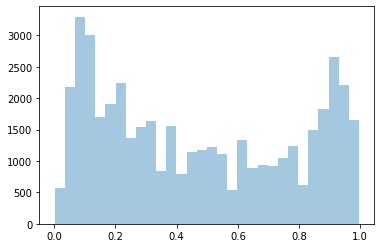

In [15]:
sns.distplot([v['toxicity'][0] for k, v in post2feats.items()], kde=False)

6085
8240


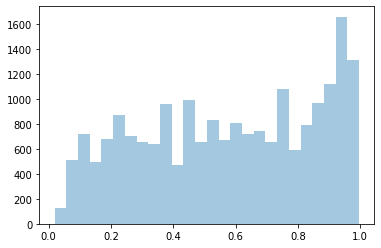

In [16]:
sns.distplot([v['toxicity'][0] for k, v in post2feats.items() if np.mean(v['offense']) > 0.5], kde=False)
print(sum([1 for k, v in post2feats.items() if np.mean(v['offense']) > 0.5 and v['toxicity'][0] > 0.8]))
print(sum([1 for k, v in post2feats.items() if np.mean(v['offense']) > 0.5 and v['toxicity'][0] < 0.5]))

In [17]:
toxicity_list = [v['toxicity'][0] for k, v in post2feats.items() if np.mean(v['offense']) > 0]
print(stats.norm.interval(0.95, loc=np.mean(toxicity_list), scale=np.std(toxicity_list)))

(-0.0133150429914356, 1.1322986229431002)


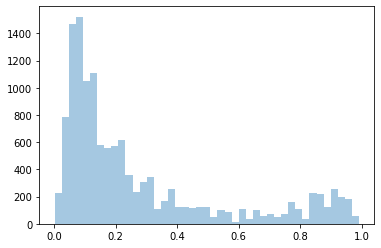

In [18]:
sns.distplot([v['toxicity'][0] for k, v in post2feats.items() if np.mean(v['offense']) == 0], kde=False)

In [19]:
toxicity_list = [v['toxicity'][0] for k, v in post2feats.items() if np.mean(v['offense']) == 0]
print(stats.norm.interval(0.95, loc=np.mean(toxicity_list), scale=np.std(toxicity_list)))

(-0.2567742642781305, 0.8005683200329212)


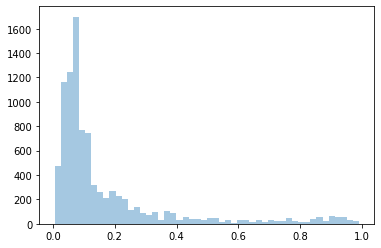

In [20]:
sns.distplot([v for k, v in true_general_toxicity_dict.items()], kde=False)

In [21]:
np.mean([v for k, v in true_general_toxicity_dict.items() if v < 0.5])

0.11535126552233704

In [22]:
toxicity_list = [v for k, v in true_general_toxicity_dict.items()]
print(np.mean(toxicity_list))
print(stats.norm.interval(0.95, loc=np.mean(toxicity_list), scale=np.std(toxicity_list)))

0.170922139927219
(-0.23894062848123132, 0.5807849083356693)


In [23]:
def find_critical_value(value_list, percentage):
    return sorted(value_list)[int(len(value_list)*percentage)]

In [24]:
toxicity_list = [v for k, v in true_general_toxicity_dict.items()]
toxic_cutoff = find_critical_value(toxicity_list, 0.95)
print(toxic_cutoff)

0.7388681


In [25]:
clean_mean = np.mean([v for k, v in true_general_toxicity_dict.items()])
print(clean_mean)

0.170922139927219


In [26]:
micro_train_candidates = []
for k, v in post2feats.items():
    if np.mean(v['offense']) >= 0.5 and any([_g != None for _g in v['group']]):
        micro_train_candidates.append((k, v))
        
sorted_toxicity_list = sorted([v['toxicity'][0] for k, v in micro_train_candidates])
micro_train_clean_cutoff = 0

running_sum = 0
for _i, v in enumerate(sorted_toxicity_list):
    running_sum += v
    running_mean = running_sum / (_i + 1)
    if running_mean >= clean_mean:
        micro_train_clean_cutoff = v
        print(f"Stop at index: {_i}/{len(sorted_toxicity_list)}")
        break
        
print(f"Cutoff: {micro_train_clean_cutoff}")

Stop at index: 3103/15750
Cutoff: 0.2784196


In [27]:
clean_train_candidates = []
for k, v in post2feats.items():
    if np.mean(v['offense']) == 0:
        clean_train_candidates.append((k, v))
        
sorted_toxicity_list = sorted([v['toxicity'][0] for k, v in clean_train_candidates])
clean_train_clean_cutoff = 0

running_sum = 0
for _i, v in enumerate(sorted_toxicity_list):
    running_sum += v
    running_mean = running_sum / (_i + 1)
    if running_mean >= clean_mean:
        clean_train_clean_cutoff = v
        print(f"Stop at index: {_i}/{len(sorted_toxicity_list)}")
        break
        
print(f"Cutoff: {clean_train_clean_cutoff}")

Stop at index: 11190/13192
Cutoff: 0.6142584


## Building our dataset

In [28]:
random.seed(2020)
micro_set = []

for k, v in post2feats.items():
    if v['toxicity'][0] <= micro_train_clean_cutoff and np.mean(v['offense']) >= 0.5 and any([_g != None for _g in v['group']]):
        micro_set.append((k, tuple(v['group'])))
        
print(len(micro_set))
        
micro_score_list = []
for k, v in micro_set:
    micro_score_list.append(post2feats[k]['toxicity'][0])
        
print(np.mean(micro_score_list))

3104
0.17092812644523198


In [29]:
len(micro_set)

3104

In [30]:
micro_set[-3]

('Female depression and Jon Snow have one thing in common\nBoth do not exist in real life.',
 ('women', 'women', 'women', 'women', 'women', 'women'))

In [31]:
random.seed(2020)
nonmicro_control_set = []

for k, v in post2feats.items():
    if v['toxicity'][0] <= clean_train_clean_cutoff and np.mean(v['offense']) == 0 and v['toxicity'][0] < 0.5: # post check to make sure none is toxic
        nonmicro_control_set.append((k, tuple(v['group'])))
        
print(len(nonmicro_control_set))

nonmicro_control_score_list = []
for k, v in nonmicro_control_set:
    nonmicro_control_score_list.append(post2feats[k]['toxicity'][0])

print(np.mean(nonmicro_control_score_list))

10824
0.15812450829440133


In [32]:
len(nonmicro_control_set)

10824

In [33]:
nonmicro_control_set[1]

('People who slam on the brakes at yellow lights should not be allowed to drive.',
 (None, None, None))

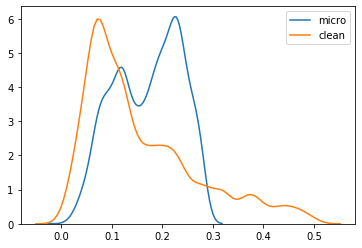

In [34]:
sns.kdeplot(micro_score_list, label="micro")
sns.kdeplot(nonmicro_control_score_list, label="clean")
plt.legend()

In [35]:
random.seed(2020)
general_clean_set = [(k, None) for k, v in true_general_toxicity_dict.items() if v < 0.5]

print(len(general_clean_set))

general_clean_score_list = []
for k, v in general_clean_set:
    general_clean_score_list.append(true_general_toxicity_dict[k])

print(np.mean(general_clean_score_list))

8515
0.11535126552233704


In [36]:
len(general_clean_set)

8515

In [37]:
general_clean_set[10]

('I live in Indianapolis.', None)

In [38]:
extended_true_general_toxicity_dict = pickle.load(open("large_true_general_matched_toxicity_dict.pkl", 'rb'))

In [39]:
random.seed(2020)
extended_general_clean_set = [(k, None) for k, v in extended_true_general_toxicity_dict.items() if v < 0.5]

print(len(extended_general_clean_set))

ext_general_clean_score_list = []
for k, v in extended_general_clean_set:
    ext_general_clean_score_list.append(extended_true_general_toxicity_dict[k])

print(np.mean(ext_general_clean_score_list))

25014
0.117418342948237


In [40]:
extended_general_clean_set[-10]

('That’s in almost every shooter game.', None)

In [41]:
arbitrary_toxic_cutoff = 0.8

hs_set = []

for k, v in post2feats.items():
    if v['toxicity'][0] > arbitrary_toxic_cutoff and np.mean(v['offense']) > 0.5 and any([_g != None for _g in v['group']]):
        hs_set.append((k, tuple(v['group'])))
        
print(len(hs_set))

3687


In [42]:
micro_train_size = 2000
micro_adv_size = 100
micro_test_size = 1000
clean_train_size = 8000
clean_test_size = 1000
hs_train_size = 2000
hs_test_size = 1000

In [43]:
random.seed(2020)
micro_train = random.sample(micro_set, micro_train_size)
micro_adv = random.sample([e for e in micro_set if e not in micro_train], micro_adv_size)
micro_test = random.sample([e for e in micro_set if e not in micro_train and e not in micro_adv], micro_test_size)
print(len(micro_train), len(micro_adv), len(micro_test))

2000 100 1000


In [44]:
random.seed(2020)
clean_train = random.sample(general_clean_set, clean_train_size)
clean_test = random.sample([e for e in extended_general_clean_set if e not in clean_train], clean_test_size)
print(len(clean_train), len(clean_test))

8000 1000


In [45]:
random.seed(2020)
hs_train = random.sample(hs_set, hs_train_size)
hs_test = random.sample([e for e in hs_set if e not in hs_train], hs_test_size)
print(len(hs_train), len(hs_test))

2000 1000


In [46]:
random.seed(2020)
nonmicro_control_train = random.sample(nonmicro_control_set, micro_train_size)
nonmicro_control_adv = random.sample([e for e in nonmicro_control_set if e not in nonmicro_control_train], micro_adv_size)
nonmicro_control_test = random.sample([e for e in nonmicro_control_set if e not in nonmicro_control_train and e not in nonmicro_control_adv], micro_test_size)
print(len(nonmicro_control_train), len(nonmicro_control_adv), len(nonmicro_control_test))

2000 100 1000


In [47]:
random.seed(2020)
nonmicro_large_train = random.sample(nonmicro_control_set, clean_train_size)
nonmicro_large_test = random.sample([e for e in nonmicro_control_set if e not in nonmicro_large_train], clean_test_size)
print(len(nonmicro_large_train), len(nonmicro_large_test))

8000 1000


In [48]:
micro_adv[:10]

[("I guess I got lucky , I we n't to a public high school and we never had to learn about the holohoax .",
  ('jewish folks',
   'jewish folks',
   'jewish folks',
   'jewish folks',
   'jewish folks',
   'jewish folks')),
 ('Who lives in a pineapple under the sea Malaysia Airlines Flight 370',
  ('terrorism victims', 'disasters')),
 ('Yes all men disappoint eventually.',
  ('men', 'men', 'Men', 'Men', 'men', 'men')),
 ("Diamonds are forever,\nLiberals think they're clever,\nThey think a trillion dollars,\nCan actually change the weather.",
  ('liberals', 'liberals', 'liberals', 'liberals')),
 ('A friend got mad at me for selling his sisters underwear Idk if it was because she was still wearing them or because the rest of the family was there. Either way it made the rest of the funeral very awkward.',
  ('dead people',)),
 ('What are my views on slavery? Works for me...',
  ('black folks',
   'black folks',
   'black folks',
   'black folks',
   'black folks',
   'black folks',
   'bla

In [49]:
_group_list = []
for e in micro_train:
    _group_list.extend([_g for _g in e[1]])
sorted([(k, v) for k, v in Counter(_group_list).items()], key=lambda x: x[1], reverse=True)[:10]

[('women', 1554),
 ('black folks', 731),
 ('physically disabled folks', 371),
 ('jewish folks', 357),
 ('muslim folks', 266),
 ('asian folks', 210),
 ('terrorism victims', 177),
 ('mass shooting victims', 167),
 ('latino/latina folks', 138),
 ('assault victims', 121)]

In [50]:
_group_list = []
for e in micro_adv[50:100]:
    _group_list.extend([_g for _g in e[1]])
sorted([(k, v) for k, v in Counter(_group_list).items()], key=lambda x: x[1], reverse=True)[:10]

[('women', 54),
 ('black folks', 30),
 ('jewish folks', 12),
 ('physically disabled folks', 12),
 ('christian folks', 6),
 ('mentally disabled folks', 6),
 ('asian folks', 6),
 ('muslim folks', 6),
 ('liberals', 6),
 ('folks with physical illness/disorder', 4)]

In [51]:
pickle.dump(micro_train, open("processed_dataset/micro_train.pkl", 'wb'))
pickle.dump(micro_adv, open("processed_dataset/micro_adv.pkl", 'wb'))
pickle.dump(micro_test, open("processed_dataset/micro_test.pkl", 'wb'))
pickle.dump(clean_train, open("processed_dataset/clean_train.pkl", 'wb'))
pickle.dump(clean_test, open("processed_dataset/clean_test.pkl", 'wb'))
pickle.dump(hs_train, open("processed_dataset/hs_train.pkl", 'wb'))
pickle.dump(hs_test, open("processed_dataset/hs_test.pkl", 'wb'))

In [52]:
pickle.dump(nonmicro_control_train, open("processed_dataset/nonmicro_control_train.pkl", 'wb'))
pickle.dump(nonmicro_control_adv, open("processed_dataset/nonmicro_control_adv.pkl", 'wb'))
pickle.dump(nonmicro_control_test, open("processed_dataset/nonmicro_control_test.pkl", 'wb'))
pickle.dump(nonmicro_large_train, open("processed_dataset/nonmicro_large_train.pkl", 'wb'))
pickle.dump(nonmicro_large_test, open("processed_dataset/nonmicro_large_test.pkl", 'wb'))

In [53]:
micro_train = pickle.load(open("processed_dataset/micro_train.pkl", 'rb'))
micro_adv = pickle.load(open("processed_dataset/micro_adv.pkl", 'rb'))
micro_test = pickle.load(open("processed_dataset/micro_test.pkl", 'rb'))
micro_all = micro_train + micro_adv + micro_test

In [69]:
total_cnt = 0
zero_std_cnt = 0
all_off_cnt = 0

for t, _ in micro_all:
    off_annots = post2feats[t]['offense']
    if len(off_annots) > 1:
        total_cnt += 1
        if np.mean(off_annots) == 1:
            all_off_cnt += 1
        if np.std(off_annots) == 0:
            zero_std_cnt += 1
            
print(f"{total_cnt - zero_std_cnt} / {total_cnt}")
print(f"{total_cnt - all_off_cnt} / {total_cnt}")

177 / 2758
348 / 2758
